In [1]:
from diskcache import Cache
import os
from Utils.data_manager import DataManager
from Utils.models import FLNet
from Clients.training import Training
import copy
import torch
from torch import nn
from Utils.analytics import Analytics
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
%load_ext autoreload
%autoreload 2
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class FULDebug:
    def __init__(self, cache, breakpoint, num_parties, num_fl_rounds):
        
        cache["breakpoint"] = breakpoint
        self.num_parties = num_parties
        self.num_fl_rounds = num_fl_rounds
        self.cache = cache
    
    def average_selected_models(self, selected_parties, party_models):
        with torch.no_grad():
            sum_vec = nn.utils.parameters_to_vector(party_models[selected_parties[0]].parameters())
            if len(selected_parties) > 1:
                for i in range(1,len(selected_parties)):
                    sum_vec += nn.utils.parameters_to_vector(party_models[selected_parties[i]].parameters())
                sum_vec /= len(selected_parties)

            model = copy.deepcopy(party_models[0])
            nn.utils.vector_to_parameters(sum_vec, model.parameters())
        return model.state_dict()
    
    def aggregate(self, client_models, current_model=None):
        selected_parties = [i for i in range(self.num_parties)]
        aggregated_model_state_dict = self.average_selected_models(selected_parties, client_models)
        return aggregated_model_state_dict 
    
    def partiesStart(self, trainloader_lst, testloader, client_to_be_erased=100, dataType="FMNIST"):

        num_fl_rounds = self.num_fl_rounds
        num_parties = self.num_parties
        initial_model = FLNet()
        model_dict = copy.deepcopy(initial_model.state_dict())
        client_models_all_rounds = []
        global_models_all_rounds = []
        for round_num in range(num_fl_rounds): 
            ##################### Local Training Round #############################
            current_model_state_dict = copy.deepcopy(model_dict)
            current_model = copy.deepcopy(initial_model)
            current_model.load_state_dict(current_model_state_dict)
            client_models = []
            party_losses = []
            for party_id in range(num_parties):

                if party_id == client_to_be_erased:
                    client_models.append(FLNet())
                else:
                    model = copy.deepcopy(current_model)
                    local_training = Training(num_updates_in_epoch=None, num_local_epochs=1)
                    model_update, party_loss = local_training.train(model=model, 
                                                trainloader=trainloader_lst[party_id], 
                                                criterion=None, opt=None, dataType=dataType)

                    client_models.append(copy.deepcopy(model_update))
                    party_losses.append(party_loss)
                    print(f"Party {party_id} Loss: {party_loss}")
            ######################################################################  
            current_model_state_dict = self.aggregate(client_models=client_models, current_model=current_model)
            model_dict = copy.deepcopy(current_model_state_dict)
            eval_model = FLNet()
            eval_model.load_state_dict(current_model_state_dict)
            clean_acc = local_training.evaluate(testloader, eval_model)
            client_models_all_rounds.append(copy.deepcopy(client_models))
            global_models_all_rounds.append(copy.deepcopy(current_model_state_dict))
            # clean_accuracy[fusion_key][round_num] = clean_acc        
            self.cache[f"client_models"] = client_models
            self.cache[f"global_models"] = current_model_state_dict
            print(f'Global Clean Accuracy, round {round_num} = {clean_acc}')
            # print(self.cache.get(f"client_models_{round_num}"))
        self.cache["client_models_all_rounds"] = client_models_all_rounds
        self.cache["global_models_all_rounds"] = global_models_all_rounds

    # Function to compute class-wise accuracy
    def compute_classwise_metrics(self, model, test_loader):
        class_correct = defaultdict(int)
        class_total = defaultdict(int)
        
        model.eval()
        
        with torch.no_grad():
            for data, labels in test_loader:
                if data.dim() == 5:  # If the image has an extra dimension, squeeze it
                    data = data.squeeze(1)  # Remove the extra dimension
                    
                # Check if the input tensor has the correct shape for CIFAR-10
                if data.shape[1] == 32:  # Indicates the channel dimension is incorrectly set as 32
                    # Permute from [batch_size, height, width, channels] to [batch_size, channels, height, width]
                    data = data.permute(0, 3, 1, 2)
                    
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                
                # Update class-wise correct/total counts
                for label, prediction in zip(labels, predicted):
                    class_total[label.item()] += 1
                    if label.item() == prediction.item():
                        class_correct[label.item()] += 1
        
        # Compute class-wise accuracies
        class_accuracies = {cls: class_correct[cls] / class_total[cls] if class_total[cls] > 0 else 0
                            for cls in class_total}
        
        return class_accuracies, class_total

    # Function to identify classes impacted by unlearning
    def identify_affected_classes(self, global_model_before, global_model_after, test_loader, threshold=0.05):
        """
        Identify the classes that are significantly impacted after unlearning client 0.
        
        :param global_model_before: The global model before unlearning.
        :param global_model_after: The global model after unlearning.
        :param test_loader: The test data loader.
        :param threshold: The threshold to consider a class significantly impacted.
        :return: A list of impacted classes.
        """
        # Compute class-wise accuracy before and after unlearning
        before_class_accuracies, _ = self.compute_classwise_metrics(global_model_before, test_loader)
        after_class_accuracies, _ = self.compute_classwise_metrics(global_model_after, test_loader)
    
        impacted_classes = []
    
        # Compare class accuracies before and after unlearning
        for cls in before_class_accuracies:
            accuracy_drop = before_class_accuracies[cls] - after_class_accuracies[cls]
            if accuracy_drop > threshold:
                impacted_classes.append(cls)
    
        return impacted_classes

    def calculate_class_weights(self, global_model_before, global_model_after, test_loader, impacted_classes):
        """
        Calculate class weights based on the accuracy difference before and after unlearning.
        
        :param global_model_before: Global model before unlearning.
        :param global_model_after: Global model after unlearning.
        :param test_loader: DataLoader for the test data.
        :param impacted_classes: List of impacted classes.
        :return: Dictionary with class indices as keys and weights as values.
        """
        # Compute class-wise accuracies before and after unlearning
        class_accuracies_before, _ = self.compute_classwise_metrics(global_model_before, test_loader)
        class_accuracies_after, _ = self.compute_classwise_metrics(global_model_after, test_loader)
        
        # Calculate the absolute difference in accuracy for each impacted class
        accuracy_diffs = {class_idx: abs(class_accuracies_before[class_idx] - class_accuracies_after[class_idx])
                          for class_idx in impacted_classes}
        
        # Normalize the differences to sum to 1 (to be used as weights)
        total_diff = sum(accuracy_diffs.values())
        class_weights = {class_idx: (diff / total_diff) for class_idx, diff in accuracy_diffs.items()} if total_diff > 0 else {class_idx: 1/len(impacted_classes) for class_idx in impacted_classes}
        
        # Print class weights for reference
        for class_idx, weight in class_weights.items():
            print(f"Class {class_idx} Weight: {weight:.4f}")
        
        return class_weights

    
    def select_clients_to_fix_bias(self, clients_models, impacted_classes, test_loader, global_model, global_model_before, global_model_after, num_clients=3, lambda_penalty=0.1):
        """
        Select clients that contribute the most to the affected classes with automated class weighting and regularization.
        
        :param clients_models: List of models for remaining clients.
        :param impacted_classes: List of classes impacted by unlearning client 0.
        :param test_loader: DataLoader for the test data.
        :param global_model: Global model to compute deviations for regularization.
        :param global_model_before: Global model before unlearning.
        :param global_model_after: Global model after unlearning.
        :param num_clients: Number of clients to select for fixing the bias.
        :param lambda_penalty: Regularization term to penalize clients with large deviations from global performance.
        :return: Tuple of (list of selected client indices, list of selected client models).
        """
        # Automatically assign class weights based on accuracy impact
        class_weights = self.calculate_class_weights(global_model_before, global_model_after, test_loader, impacted_classes)
    
        client_contributions = []
        
        # Compute global model's class-wise accuracy for regularization
        global_class_accuracies, _ = self.compute_classwise_metrics(global_model, test_loader)
        
        # Compute class-wise accuracy for each client
        for client_idx, client_model in enumerate(clients_models):
            class_accuracies, _ = self.compute_classwise_metrics(client_model, test_loader)
            
            # Calculate the weighted contribution of this client to the impacted classes
            contribution = sum((class_accuracies[class_idx] * class_weights[class_idx]) for class_idx in impacted_classes)
            
            # Compute the regularization term: deviation from the global model
            deviation_penalty = sum(abs(class_accuracies[class_idx] - global_class_accuracies[class_idx]) for class_idx in impacted_classes)
            
            # Final score: contribution minus regularization penalty
            final_contribution = contribution - lambda_penalty * deviation_penalty
            
            client_contributions.append((client_idx, client_model, final_contribution))
        
        # Sort clients by their final contribution score
        client_contributions.sort(key=lambda x: x[2], reverse=True)
        
        # Select top clients to fix the bias
        selected_clients = client_contributions[:num_clients]
        
        # Extract client indices and models for the selected clients
        selected_client_indices = [client_idx for client_idx, _, _ in selected_clients]
        selected_client_models = [client_model for _, client_model, _ in selected_clients]
        
        # Print selected clients and their contributions
        for client_idx, _, contribution in selected_clients:
            print(f"Selected Client {client_idx} with Contribution: {contribution:.4f}")
        
        # Return both selected client indices and models
        return selected_client_models, selected_client_indices


    def unlearnedModelAggregationWithSelectedClients(self, trainloader_lst, testloader, unlearned_model, num_rounds=10, client_to_be_erased=100, select_clients_method='random', select_num_clients=6):
    
        num_parties = self.num_parties
        initial_model = FLNet()
        current_model_state_dict = copy.deepcopy(unlearned_model.state_dict())  
        initial_model.load_state_dict(current_model_state_dict)  
        model_dict = copy.deepcopy(initial_model.state_dict())

        model_before = self.cache.get('initial_model')
        model_before.load_state_dict(self.cache.get('global_models'))
        model_before.eval()
        
        model_after = self.cache.get('initial_model')
        model_after.load_state_dict(self.cache.get("unlearned_model").state_dict())
        model_after.eval()
        
        client_model = self.cache.get('initial_model')
        client_model.load_state_dict(self.cache.get("client_models")[0].state_dict())
        client_model.eval()
        
        global_model_accuracies = []
        for round_num in range(num_rounds): 
            ##################### Local Training Round #############################
            current_model_state_dict = copy.deepcopy(model_dict)
            current_model = copy.deepcopy(initial_model)
            current_model.load_state_dict(current_model_state_dict)
            client_models = []
            party_losses = []
    
            for party_id in range(num_parties):
                if party_id == client_to_be_erased:
                    client_models.append(FLNet())  # Placeholder for unlearned client
                else:
                    model = copy.deepcopy(current_model)
                    local_training = Training(num_updates_in_epoch=None, num_local_epochs=1)
                    model_update, party_loss = local_training.train(model=model, 
                                                    trainloader=trainloader_lst[party_id], 
                                                    criterion=None, opt=None, dataType="CIFAR")
    
                    client_models.append(copy.deepcopy(model_update))
                    party_losses.append(party_loss)
                    print(f"Party {party_id} Loss: {party_loss}")
    
            ###################### Client Selection ###############################
            impacted_classes = self.identify_affected_classes(model_before, model_after, testDataloader, threshold=0.05)
            selected_client_models, selected_client_indices = self.select_clients_to_fix_bias(client_models, impacted_classes, testDataloader, model_before, model_before, model_after, num_clients=5)
            print(selected_client_models)
    
            #######################################################################
            # Aggregate only the selected client models
            current_model_state_dict = self.unlearnAggregate(client_models=selected_client_models, client_to_be_erased=client_to_be_erased)
            model_dict = copy.deepcopy(current_model_state_dict)
            eval_model = FLNet()
            eval_model.load_state_dict(current_model_state_dict)
    
            clean_acc = local_training.evaluate(testloader, eval_model)
            print(f'Global Clean Accuracy, round {round_num} = {clean_acc}')
            global_model_accuracies.append(clean_acc)
            self.cache[f"unlearning_client_models_with_FULDebug"] = client_models
            self.cache[f"unlearning_global_models_with_FULDebug"] = current_model_state_dict
            model_after = self.cache.get('initial_model')
            model_after.load_state_dict(current_model_state_dict)
            model_after.eval()
        return global_model_accuracies
    
    def unlearnAggregate(self, client_models, client_to_be_erased):
        selected_parties = [i for i in range(len(client_models))]
        aggregated_model_state_dict = self.average_selected_models(selected_parties, client_models)
        return aggregated_model_state_dict
    
    def unlearnedModelAggregation(self, trainloader_lst, testloader, unlearned_model, num_rounds=10, client_to_be_erased=100):

        num_parties = self.num_parties
        initial_model = FLNet()
        current_model_state_dict = copy.deepcopy(unlearned_model.state_dict())  
        initial_model.load_state_dict(current_model_state_dict)  
        model_dict = copy.deepcopy(initial_model.state_dict())
        for round_num in range(num_rounds): 
            ##################### Local Training Round #############################
            current_model_state_dict = copy.deepcopy(model_dict)
            current_model = copy.deepcopy(initial_model)
            current_model.load_state_dict(current_model_state_dict)
            client_models = []
            party_losses = []
            for party_id in range(num_parties):

                if party_id == client_to_be_erased:
                    client_models.append(FLNet())
                else:
                    model = copy.deepcopy(current_model)
                    local_training = Training(num_updates_in_epoch=None, num_local_epochs=1)
                    model_update, party_loss = local_training.train(model=model, 
                                                trainloader=trainloader_lst[party_id], 
                                                criterion=None, opt=None, dataType="FMNIST")

                    client_models.append(copy.deepcopy(model_update))
                    party_losses.append(party_loss)
                    print(f"Party {party_id} Loss: {party_loss}")
            ######################################################################  
            current_model_state_dict = self.unlearnAggregate(client_models=client_models, client_to_be_erased=client_to_be_erased)
            model_dict = copy.deepcopy(current_model_state_dict)
            eval_model = FLNet()
            eval_model.load_state_dict(current_model_state_dict)
            clean_acc = local_training.evaluate(testloader, eval_model)
            # clean_accuracy[fusion_key][round_num] = clean_acc      
            self.cache[f"unlearning_client_models"] = client_models
            self.cache[f"unlearning_global_models"] = current_model_state_dict
            print(f'Global Clean Accuracy, round {round_num} = {clean_acc}')

    def compute_weight_contribution(self, global_model, client_updates, selected_client_idx):
        """
        Compute the influence of each client's weight contribution to the global model.

        :param global_model: The baseline global model (PyTorch model)
        :param client_updates: List of model updates from each client (list of state_dicts)
        :param selected_client_idx: Index of the client whose contribution you want to analyze
        :return: Difference between the global model's weights with and without the selected client's contribution
        """
        # Compute the average weight update with all clients
        num_clients = len(client_updates)
        avg_update = {key: torch.zeros_like(val) for key, val in client_updates[0].state_dict().items()}

        for update in client_updates:
            for key in update.state_dict():
                avg_update[key] += update.state_dict()[key] / num_clients

        # Compute the average weight update without the selected client
        avg_update_without_client = {key: torch.zeros_like(val) for key, val in client_updates[0].state_dict().items()}

        for i, update in enumerate(client_updates):
            if i == selected_client_idx:
                continue  # Skip the selected client
            for key in update.state_dict():
                avg_update_without_client[key] += update.state_dict()[key] / (num_clients - 1)

        # Calculate the difference in the global model's weights
        weight_difference = {key: avg_update[key] - avg_update_without_client[key] for key in avg_update}

        return weight_difference

    def compute_weight_norm_difference(self, weight_difference):
        """
        Computes the norm of the weight differences to quantify the impact.

        :param weight_difference: Dictionary containing weight differences for each layer
        :return: Dictionary with norms for each layer
        """
        norm_diff = {}
        for layer, diff in weight_difference.items():
            norm_diff[layer] = torch.norm(diff).item()
        return norm_diff
    
    def analyze_class_bias(self, global_model, weight_difference, num_classes=10):
        """
        Analyzes the class-specific impact of removing a client's weight contribution.

        :param global_model: The baseline global model (PyTorch model)
        :param weight_difference: Difference in weights with and without the selected client's contribution
        :param num_classes: Number of classes in the dataset (e.g., 10 for MNIST)
        :return: Impact on each class based on output layer weight differences
        """
        output_layer_key = None

        # Identify the output layer by checking for the appropriate layer name
        for key in weight_difference.keys():
            if 'weight' in key and weight_difference[key].shape[0] == num_classes:
                output_layer_key = key
                break

        if output_layer_key is None:
            raise ValueError("Could not identify the output layer in the model.")

        # Analyze the impact on each class
        class_impact = torch.norm(weight_difference[output_layer_key], dim=1).tolist()
        return class_impact

    def summarize_and_print_results(slef, norm_diff, class_impact):
        """
        Summarizes and prints the results of the weight differences and class impacts.

        :param norm_diff: Dictionary containing the norms of weight differences for each layer
        :param class_impact: List containing the impact on each class
        """
        print("=== Summary of Weight Differences by Layer ===")
        print(f"{'Layer':<20} {'Norm Difference':>20}")
        print("-" * 40)
        
        for layer, norm in norm_diff.items():
            print(f"{layer:<20} {norm:>20.6f}")
        
        print("\n=== Impact on Each Class ===")
        print(f"{'Class':<10} {'Impact':>10}")
        print("-" * 25)
        
        for class_idx, impact in enumerate(class_impact):
            print(f"Class {class_idx:<5} {impact:>10.6f}")
        
        print("\n=== Analysis ===")
        
        # Find the class with the maximum and minimum impact
        max_impact_class = max(range(len(class_impact)), key=lambda i: class_impact[i])
        min_impact_class = min(range(len(class_impact)), key=lambda i: class_impact[i])
        
        print(f"The highest impact is on Class {max_impact_class} with an impact value of {class_impact[max_impact_class]:.6f}.")
        print(f"The lowest impact is on Class {min_impact_class} with an impact value of {class_impact[min_impact_class]:.6f}.")

        # Determine which layers are most and least affected
        most_affected_layer = max(norm_diff, key=norm_diff.get)
        least_affected_layer = min(norm_diff, key=norm_diff.get)
        
        print(f"The most affected layer is '{most_affected_layer}' with a norm difference of {norm_diff[most_affected_layer]:.6f}.")
        print(f"The least affected layer is '{least_affected_layer}' with a norm difference of {norm_diff[least_affected_layer]:.6f}.")
        print("\nThis analysis suggests that removing the selected client's contribution mainly affects the above class and layer.")



/home/ubuntu/workspace/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Initialize the cache
cache = Cache('./cache-fedrecovery10', size_limit=5 * 10**9)
initial_model = FLNet()
cache["initial_model"] = initial_model
breakpoint =  {"round": 5, "status": False}
# Initialize the MNIST loader
loader = DataManager(download_dir="./data", normalize=True)
# Load the MNIST data
(x_train, y_train), (x_test, y_test) = loader.load_mnist()
# dataLoader = loader.split_data_uneven(x_train, y_train)
# dataLoader = loader.split_data_label_flipping(x_train, y_train)
# dataLoader = loader.split_data_dirichlet(x_train, y_train)
# dataLoader = loader.split_data_shards_rare_classes(x_train, y_train)
dataLoader = loader.split_data_extreme_minority_two(x_train, y_train)
testDataloader = loader.get_test_dataloader(x_test, y_test)
print(testDataloader)

In [4]:
parties = 10
sim = FULDebug(cache, breakpoint, parties, 10)
sim.partiesStart(dataLoader, testDataloader)

Party 0 Loss: 1.0896259568500937
Party 1 Loss: 2.2119258490014584
Party 2 Loss: 2.2150271293964794
Party 3 Loss: 2.0913795577852348
Party 4 Loss: 2.0931004725004496
Party 5 Loss: 2.0964640598548088
Party 6 Loss: 2.0952250016363045
Party 7 Loss: 2.094515273445531
Party 8 Loss: 2.092556219351919
Party 9 Loss: 2.087539148958106
Global Clean Accuracy, round 0 = 63.34
Party 0 Loss: 0.7162447310984135
Party 1 Loss: 1.0515829660791032
Party 2 Loss: 1.0766552509145533
Party 3 Loss: 0.8299826148309206
Party 4 Loss: 0.8083549832042894
Party 5 Loss: 0.8316302283814079
Party 6 Loss: 0.8222200274467468
Party 7 Loss: 0.8011577270532909
Party 8 Loss: 0.8365957752654427
Party 9 Loss: 0.8231013628997301
Global Clean Accuracy, round 1 = 73.18
Party 0 Loss: 0.30827954052048817
Party 1 Loss: 0.42813744380119
Party 2 Loss: 0.4089311459597121
Party 3 Loss: 0.3197718721471335
Party 4 Loss: 0.30034668076979487
Party 5 Loss: 0.3165803343841904
Party 6 Loss: 0.2961968975631814
Party 7 Loss: 0.3128405527064675
P

In [5]:
from Ful_Algo.fedrecovery import FedRecovery  # or wherever your FedRecovery class is located
%load_ext autoreload
%autoreload 2

# Usage example
fedrecovery_instance = FedRecovery(
    device=device,  # e.g., torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    old_global_model_list=cache.get("global_models_all_rounds"),   # historical global models (list of state_dicts)
    old_local_model_list=cache.get("client_models_all_rounds"),    # historical client models (list of lists of state_dicts)
    ul_client=0,                  # ID of the party to be unlearned
    base_model=FLNet(),           # your FLNet() or another architecture
    train_loader=testDataloader,  # or dataLoader if you want the "train" set for evaluation
    val_loader=testDataloader,    # or a separate validation loader
    ul_loader=dataLoader[0],     # or a specialized "unlearn" loader (poison set, etc.)
    std_list=[0.02, 0.025, 0.03], # noise std values to try
    num_classes=10,
    seed=42,
    num_users=10,
    batch_size=32,
    iid=True,
    lr=0.01,
    noise_scale=10.0  # factor for gradient residual correction
)

# Execute FedRecovery
# This returns the final model after the last std is used.
recovered_model = fedrecovery_instance.execute_fedrecovery()
unlearned_model = recovered_model
# If you want to store it in the cache
cache["unlearned_model"]= recovered_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[FedRecovery] std=0.020 | Train Loss=0.3203, Train Acc=89.67% | Val Loss=0.3203, Val Acc=89.67% | UL Loss=0.7614, UL Effect=26.47%
[FedRecovery] std=0.025 | Train Loss=0.3954, Train Acc=86.58% | Val Loss=0.3954, Val Acc=86.58% | UL Loss=1.0222, UL Effect=36.56%
[FedRecovery] std=0.030 | Train Loss=0.4733, Train Acc=85.27% | Val Loss=0.4733, Val Acc=85.27% | UL Loss=0.9323, UL Effect=31.44%


In [6]:
sim = FULDebug(cache, breakpoint, parties, 10)
global_model_accuracies_without_FULDebug = sim.unlearnedModelAggregation(dataLoader, testDataloader, unlearned_model, num_rounds=5, client_to_be_erased=0)

Party 1 Loss: 0.20962527568670028
Party 2 Loss: 0.18512939249581478
Party 3 Loss: 0.1429772657391272
Party 4 Loss: 0.14610622117393895
Party 5 Loss: 0.1453826356875269
Party 6 Loss: 0.1294364665978049
Party 7 Loss: 0.12487080320715904
Party 8 Loss: 0.15031803713033073
Party 9 Loss: 0.12576116886185973
Global Clean Accuracy, round 0 = 84.19
Party 1 Loss: 0.17598331925716806
Party 2 Loss: 0.17422156844367373
Party 3 Loss: 0.11542144202088055
Party 4 Loss: 0.10310231100179647
Party 5 Loss: 0.10916415288260109
Party 6 Loss: 0.10264582118313563
Party 7 Loss: 0.10132869117354092
Party 8 Loss: 0.10238554495337762
Party 9 Loss: 0.09857499364175294
Global Clean Accuracy, round 1 = 85.72
Party 1 Loss: 0.1841905061551865
Party 2 Loss: 0.17937582620280854
Party 3 Loss: 0.11697821181855704
Party 4 Loss: 0.10750865789228364
Party 5 Loss: 0.10893040679787334
Party 6 Loss: 0.0991706947158826
Party 7 Loss: 0.10000578421903283
Party 8 Loss: 0.10187105305100742
Party 9 Loss: 0.09753150041950376
Global Cl

In [7]:
global_model_accuracies_with_FULDebug = sim.unlearnedModelAggregationWithSelectedClients(dataLoader, testDataloader, unlearned_model, num_rounds=5, client_to_be_erased=0)

Party 1 Loss: 0.1864361972250837
Party 2 Loss: 0.1970513420219117
Party 3 Loss: 0.16391467861831188
Party 4 Loss: 0.14410189362732986
Party 5 Loss: 0.1658867162309195
Party 6 Loss: 0.12763169795078666
Party 7 Loss: 0.15217191137765584
Party 8 Loss: 0.15739706786055313
Party 9 Loss: 0.13446838751827417
Class 0 Weight: 0.2539
Class 5 Weight: 0.2012
Class 8 Weight: 0.5450
Selected Client 1 with Contribution: 0.9224
Selected Client 2 with Contribution: 0.9120
Selected Client 7 with Contribution: 0.4037
Selected Client 6 with Contribution: 0.3967
Selected Client 4 with Contribution: 0.3843
[FLNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
), FLNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size

In [ ]:
# Combine both arrays into a DataFrame
import pandas as pd
filename = "results_mnist_client_selection_effiency_federaser-25.csv"
df = pd.DataFrame({
    'Without_FULDebug': global_model_accuracies_without_FULDebug,
    'With_FULDebug': global_model_accuracies_with_FULDebug
})

# Save the DataFrame to a CSV file
df.to_csv(filename, index=False)
print(f"Accuracies saved to {filename}")

In [8]:
%load_ext autoreload
%autoreload 2

analytics = Analytics(cache)
analytics.client_vs_global_per_class_accuracy(0, testDataloader)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
### Client {client_idx} vs Global Model Per Class Accuracy ###
Client Model Accuracy = 96.62%, Global Model Before Accuracy = 97.05%
Class 0: Client Model Accuracy = 98.98%, Global Model Before Accuracy = 98.88%
Class 1: Client Model Accuracy = 99.65%, Global Model Before Accuracy = 94.80%
Class 2: Client Model Accuracy = 96.12%, Global Model Before Accuracy = 97.29%
Class 3: Client Model Accuracy = 98.71%, Global Model Before Accuracy = 97.33%
Class 4: Client Model Accuracy = 96.44%, Global Model Before Accuracy = 98.07%
Class 5: Client Model Accuracy = 95.18%, Global Model Before Accuracy = 96.64%
Class 6: Client Model Accuracy = 97.39%, Global Model Before Accuracy = 98.33%
Class 7: Client Model Accuracy = 95.23%, Global Model Before Accuracy = 97.86%
Class 8: Client Model Accuracy = 93.12%, Global Model Before Accuracy = 96.92%
Class 9: Client Model Accuracy = 94.85%, Global Model Before Accurac

In [9]:
analytics.unlearned_model_vs_global_per_class_accuracy(testDataloader)

### Unlearned vs Global Model Per Class Accuracy ###
Unlearned Model Accuracy = 94.09%, Global Model Before Accuracy = 97.05%
Class 0: Global Model Before = 98.88%, After = 98.57%, Δ = -0.31%
Class 1: Global Model Before = 94.80%, After = 82.03%, Δ = -12.78%
Class 2: Global Model Before = 97.29%, After = 94.67%, Δ = -2.62%
Class 3: Global Model Before = 97.33%, After = 96.44%, Δ = -0.89%
Class 4: Global Model Before = 98.07%, After = 95.52%, Δ = -2.55%
Class 5: Global Model Before = 96.64%, After = 95.63%, Δ = -1.01%
Class 6: Global Model Before = 98.33%, After = 96.76%, Δ = -1.57%
Class 7: Global Model Before = 97.86%, After = 94.84%, Δ = -3.02%
Class 8: Global Model Before = 96.92%, After = 94.35%, Δ = -2.57%
Class 9: Global Model Before = 94.75%, After = 94.05%, Δ = -0.69%
######


In [10]:
analytics.global_before_vs_global_after_per_class_accuracy(testDataloader)


### Unlearned vs Global Model Per Class Accuracy ###
Global Model After Accuracy = 97.37%, Global Model Before Accuracy = 97.05%
Class 0: Global Model Before = 98.88%, After = 98.88%, Δ = 0.00%
Class 1: Global Model Before = 94.80%, After = 95.77%, Δ = 0.97%
Class 2: Global Model Before = 97.29%, After = 97.38%, Δ = 0.10%
Class 3: Global Model Before = 97.33%, After = 98.12%, Δ = 0.79%
Class 4: Global Model Before = 98.07%, After = 98.37%, Δ = 0.31%
Class 5: Global Model Before = 96.64%, After = 97.53%, Δ = 0.90%
Class 6: Global Model Before = 98.33%, After = 97.91%, Δ = -0.42%
Class 7: Global Model Before = 97.86%, After = 97.37%, Δ = -0.49%
Class 8: Global Model Before = 96.92%, After = 97.02%, Δ = 0.10%
Class 9: Global Model Before = 94.75%, After = 95.64%, Δ = 0.89%
######


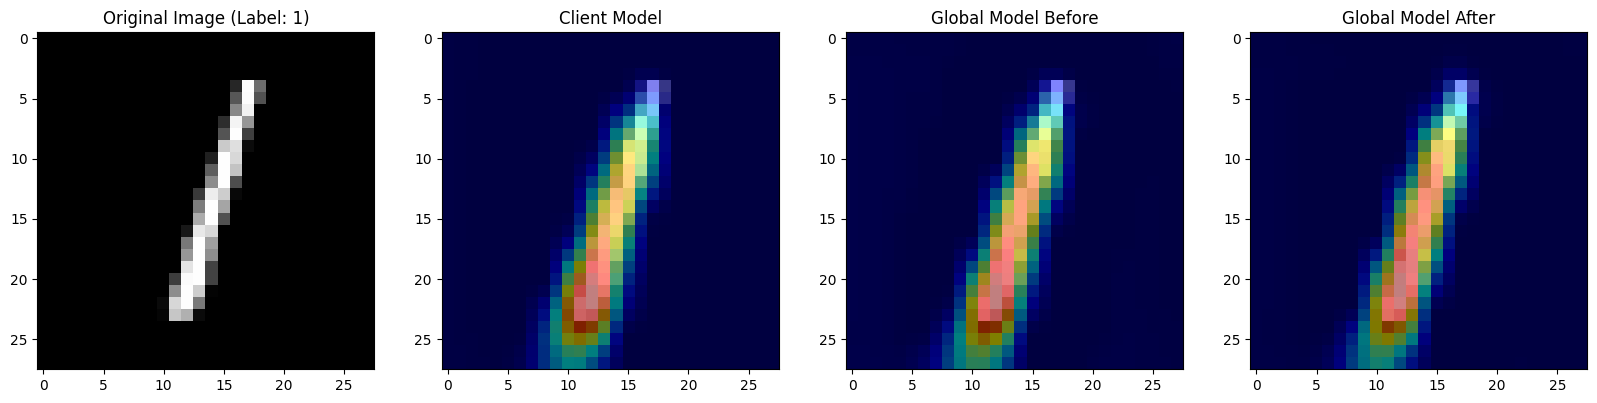

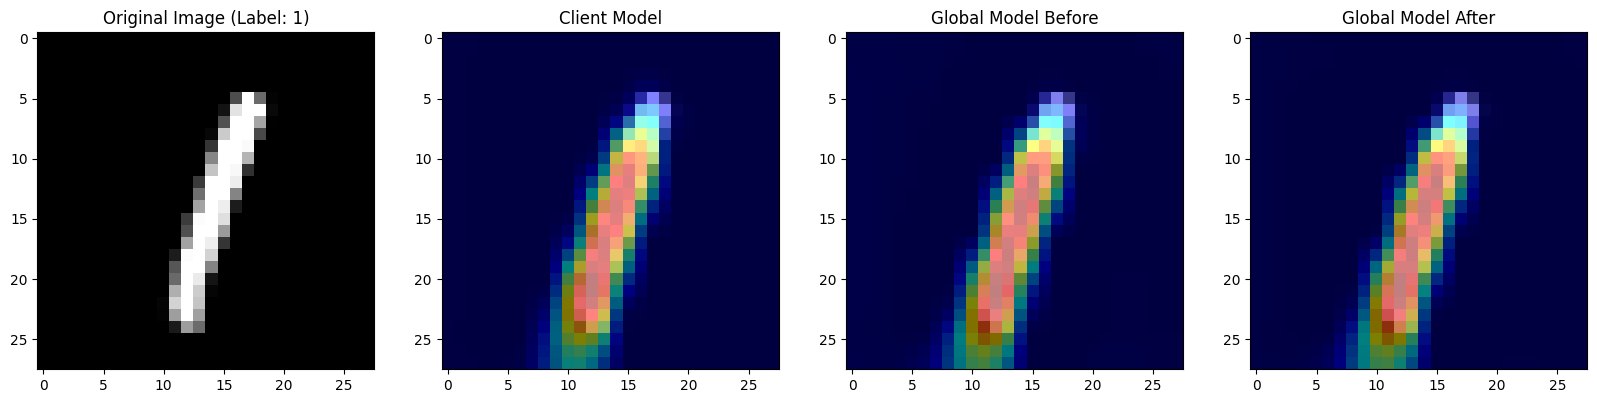

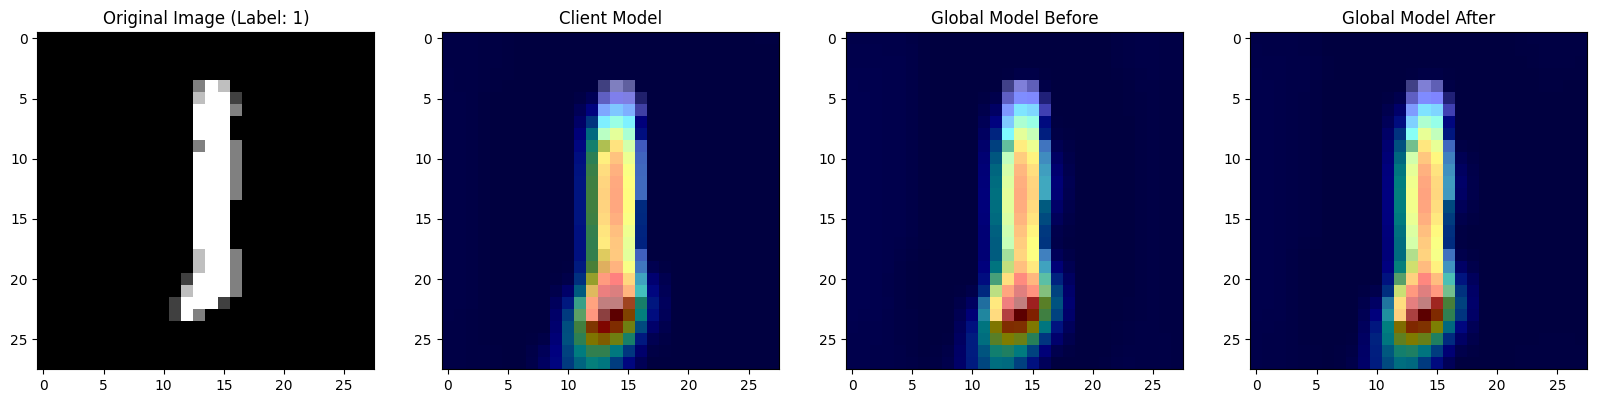

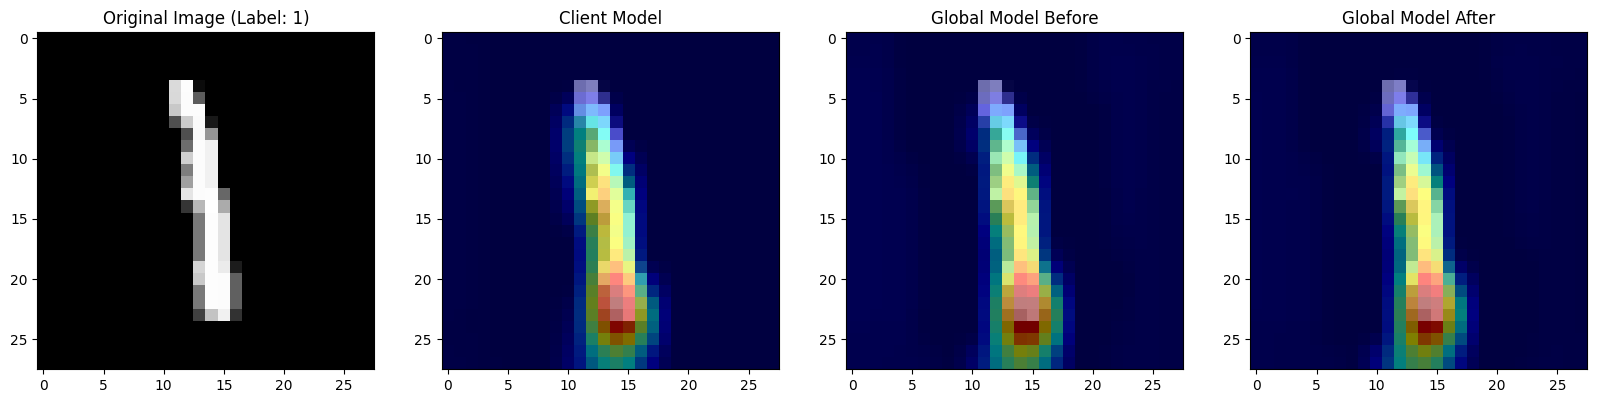

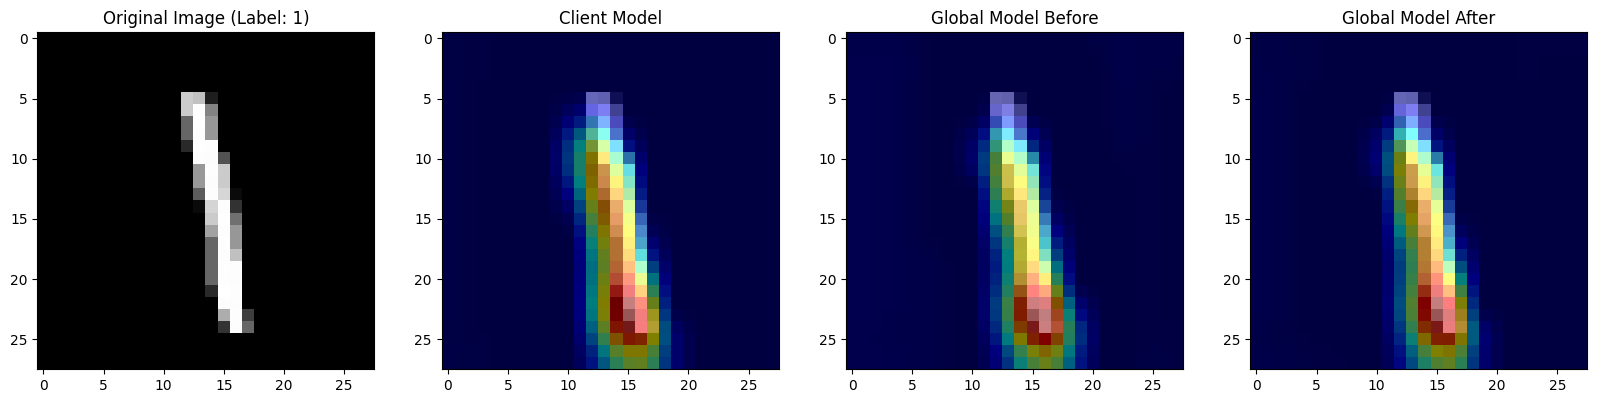

In [11]:
analytics.visualize_feature_comparison(client_idx=0, testDataloader=testDataloader, num_images_to_visualize=5, visualization_class=1)

In [12]:
analytics.display_classwise_metrics(0, testDataloader)


Class 0:
  Accuracy:
    Client Model:      |||||||||||||||||||||||||||||| (0.99)
    Global Before:     |||||||||||||||||||||||||||||| (0.99)
    Global After:      |||||||||||||||||||||||||||||| (0.99)
  Confidence:
    Client Model:      |||||||||||||||||||||||||||||| (0.98)
    Global Before:     |||||||||||||||||||||||||||||- (0.98)
    Global After:      |||||||||||||||||||||||||||||- (0.98)
---

Class 1:
  Accuracy:
    Client Model:      |||||||||||||||||||||||||||||| (1.00)
    Global Before:     |||||||||||||||||||||||||||||- (0.95)
    Global After:      |||||||||||||||||||||||||||||- (0.96)
  Confidence:
    Client Model:      |||||||||||||||||||||||||||||| (0.99)
    Global Before:     |||||||||||||||||||||||||----- (0.85)
    Global After:      |||||||||||||||||||||||||||--- (0.88)
---

Class 2:
  Accuracy:
    Client Model:      |||||||||||||||||||||||||||||- (0.96)
    Global Before:     |||||||||||||||||||||||||||||- (0.97)
    Global After:      |||||||||||||||||||||

In [13]:
analytics.display_feature_summary(0, testDataloader)


Class 0:
Client Model 0:                  ||||||||||||||||||||---------- (0.0137)
Global Model Before Unlearning:  ||||||||||||||||||||---------- (0.0135)
Global Model After Unlearning:   |||||||||||||||||||----------- (0.0130)

Class 1:
Client Model 0:                  |||||||||||||||||------------- (0.0116)
Global Model Before Unlearning:  ||||||||||||||---------------- (0.0099)
Global Model After Unlearning:   ||||||||||||||---------------- (0.0099)

Class 2:
Client Model 0:                  |||||||||||||||||------------- (0.0115)
Global Model Before Unlearning:  ||||||||||||||||-------------- (0.0112)
Global Model After Unlearning:   ||||||||||||||||-------------- (0.0112)

Class 3:
Client Model 0:                  ||||||||||||||||||------------ (0.0121)
Global Model Before Unlearning:  ||||||||||||||||||------------ (0.0122)
Global Model After Unlearning:   |||||||||||||||||||----------- (0.0128)

Class 4:
Client Model 0:                  ||||||||||||||||||||||||||||-- (0.0190)
G

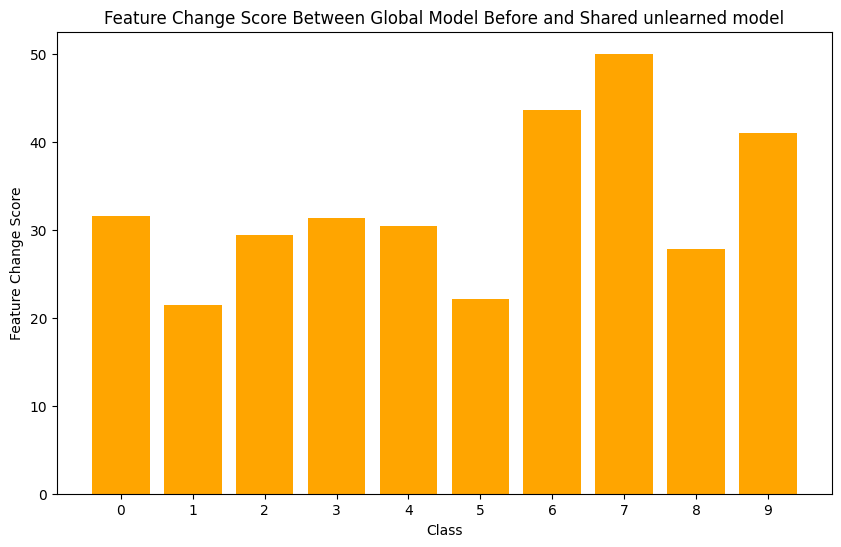

In [14]:
analytics.visualize_feature_change_class_wise_shared_unlearned_model(client_idx=0, testDataloader=testDataloader)

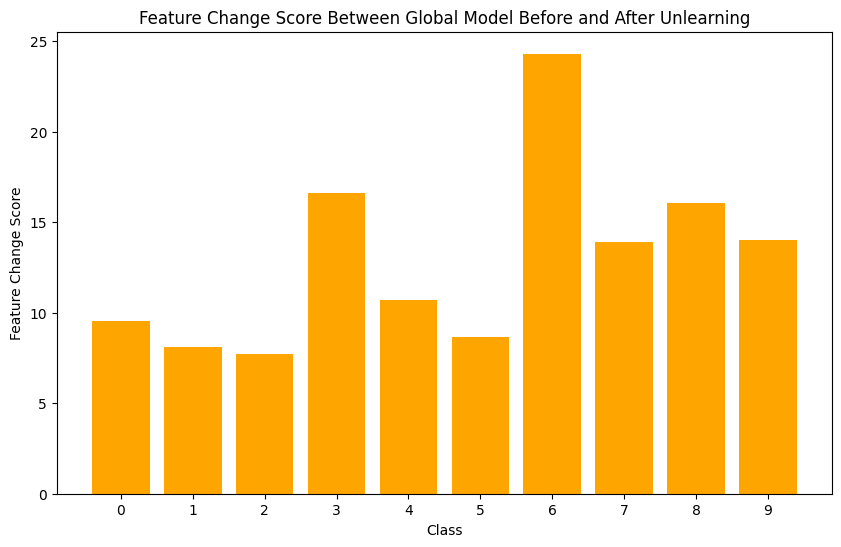

In [15]:
analytics.visualize_feature_change_class_wise(client_idx=0, testDataloader=testDataloader)

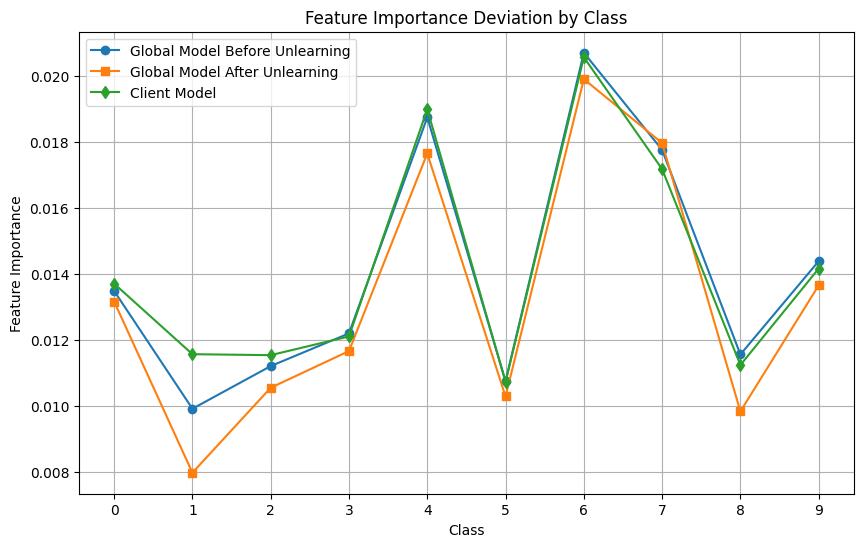

In [16]:
analytics.plot_mean_feature_deviation(client_idx=0, test_loader=testDataloader)

In [19]:
import torch
import torch.nn.functional as F

# Load models
model_before = cache.get('initial_model')
model_before.load_state_dict(cache.get('global_models'))
model_before.eval()

model_after = cache.get('initial_model')
model_after.load_state_dict(cache.get("unlearned_model").state_dict())
model_after.eval()


# Function to generate robust proxy data using Client 0's model with data augmentation and confidence filtering
def generate_proxy_data(client_model, data_loader, num_samples=100, confidence_threshold=0.9):
    proxy_data, proxy_labels = [], []
    
    client_model.eval()
    
    with torch.no_grad():
        for data, _ in data_loader:
            if len(proxy_data) >= num_samples:
                break
            if data.dim() == 5:  # If the image has an extra dimension, squeeze it
                data = data.squeeze(1)  # Remove the extra dimension
            # Get predictions and confidence scores from Client 0's model
            outputs = client_model(data)
            probs = F.softmax(outputs, dim=1)  # Get probability distribution
            confidences, predicted = torch.max(probs, dim=1)  # Max confidence and predicted labels
            
            # Filter based on confidence threshold
            high_confidence_mask = confidences >= confidence_threshold
            if high_confidence_mask.sum() > 0:
                high_confidence_data = data[high_confidence_mask]
                high_confidence_labels = predicted[high_confidence_mask]

                # Data augmentation (optional): Add slight variations to the high-confidence data
                augmented_data = augment_data(high_confidence_data)
                
                # Add the high-confidence data and its pseudo-labels to the proxy dataset
                proxy_data.append(augmented_data)
                proxy_labels.append(high_confidence_labels)

            # Stop if we have enough samples
            if len(proxy_data) >= num_samples:
                break
    
    return torch.cat(proxy_data), torch.cat(proxy_labels)

# Function to augment data (simple example with noise and flipping)
def augment_data(data):
    noise = torch.randn_like(data) * 0.02  # Add random noise
    augmented_data = data + noise
    
    # Random horizontal flips
    augmented_data = torch.flip(augmented_data, dims=[-1]) if torch.rand(1).item() > 0.5 else augmented_data
    
    return augmented_data

# Function to evaluate the model on the proxy dataset and calculate accuracy
def evaluate_on_proxy_data(model, proxy_data, proxy_labels):
    model.eval()
    with torch.no_grad():
        outputs = model(proxy_data)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == proxy_labels).sum().item()
    accuracy = correct / len(proxy_labels)
    
    # Optionally, you can also return logits/confidence scores for further analysis
    confidence_scores = torch.softmax(outputs, dim=1).max(dim=1).values
    return accuracy, confidence_scores


for i in range (0,10):
    client_model = cache.get('initial_model')
    client_model.load_state_dict(cache.get("client_models")[i].state_dict())
    client_model.eval()  
    
    # Generate robust proxy data using random inputs or synthetic data with confidence filtering
    proxy_data, proxy_labels = generate_proxy_data(client_model, testDataloader, num_samples=100, confidence_threshold=0.8)
    # Evaluate the global model before and after unlearning
    accuracy_before, confidences_before = evaluate_on_proxy_data(model_before, proxy_data, proxy_labels)
    accuracy_after, confidences_after = evaluate_on_proxy_data(model_after, proxy_data, proxy_labels)
    accuracy_drop = accuracy_before - accuracy_after 
    if accuracy_drop > 0.01:
        print(f"Unlearning was successful for client {i:.2f}. Accuracy dropped by {accuracy_drop:.2f} (from {accuracy_before:.2f} to {accuracy_after:.2f})")
    else:
        print(f"Unlearning was not successful {i:.2f}. Accuracy only dropped by {accuracy_drop:.2f} (from {accuracy_before:.2f} to {accuracy_after:.2f})")


Unlearning was successful for client 0.00. Accuracy dropped by 0.01 (from 0.64 to 0.63)
Unlearning was not successful 1.00. Accuracy only dropped by 0.01 (from 0.58 to 0.57)
Unlearning was successful for client 2.00. Accuracy dropped by 0.02 (from 0.77 to 0.75)
Unlearning was not successful 3.00. Accuracy only dropped by -0.00 (from 0.54 to 0.55)
Unlearning was not successful 4.00. Accuracy only dropped by -0.00 (from 0.82 to 0.83)
Unlearning was not successful 5.00. Accuracy only dropped by 0.01 (from 0.77 to 0.77)
Unlearning was not successful 6.00. Accuracy only dropped by 0.00 (from 0.77 to 0.77)
Unlearning was not successful 7.00. Accuracy only dropped by -0.00 (from 0.65 to 0.65)
Unlearning was not successful 8.00. Accuracy only dropped by 0.00 (from 0.71 to 0.71)
Unlearning was not successful 9.00. Accuracy only dropped by -0.00 (from 0.66 to 0.66)


Global Model Before Unlearning Accuracy: 92.62%
Unlearned Model Accuracy: 82.91%
Unlearned Model Accuracy with FulDebug: 87.24%
Client Model Accuracy: 95.45%


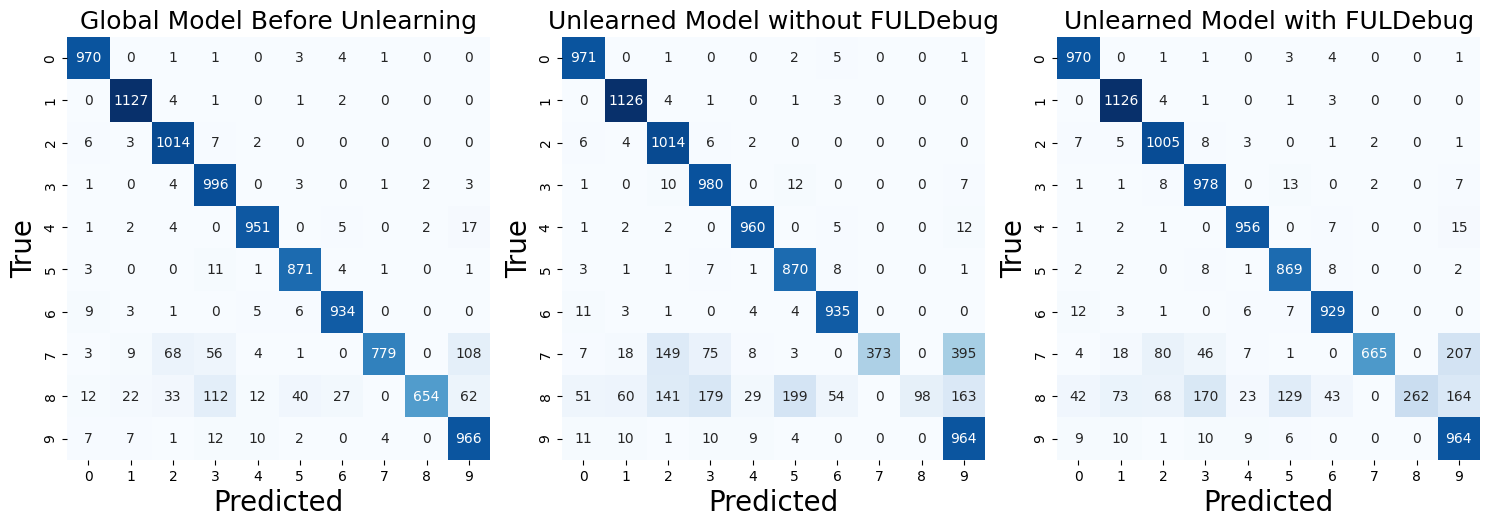

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

# Assume these models are retrieved from your cache as in your snippet:
unlearned_model = cache.get('initial_model')
unlearned_model.load_state_dict(cache.get("unlearning_global_models"))
unlearned_model.eval()

unlearned_model_with_fuldebug = cache.get('initial_model')
unlearned_model_with_fuldebug.load_state_dict(cache.get("unlearning_global_models_with_FULDebug"))
unlearned_model_with_fuldebug.eval()

global_model_before = cache.get('initial_model')
global_model_before.load_state_dict(cache.get("global_models"))
global_model_before.eval()

client_model = cache.get('initial_model')
client_model.load_state_dict(cache.get("client_models")[0].state_dict())
client_model.eval()

# Prepare the test dataset (MNIST)
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

def evaluate_model(model, dataloader, device='cpu'):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Evaluate each model on the test dataset
labels_global, preds_global = evaluate_model(global_model_before, test_loader, device)
labels_unlearned, preds_unlearned = evaluate_model(unlearned_model, test_loader, device)
labels_unlearned_with_fuldebug, preds_unlearned_with_fuldebug = evaluate_model(unlearned_model_with_fuldebug, test_loader, device)
labels_client, preds_client = evaluate_model(client_model, test_loader, device)

# Calculate confusion matrices and accuracies
cm_global = confusion_matrix(labels_global, preds_global)
cm_unlearned_without_fuldebug = confusion_matrix(labels_unlearned, preds_unlearned)
cm_unlearned_with_fuldebug = confusion_matrix(labels_unlearned_with_fuldebug, preds_unlearned_with_fuldebug)
cm_client = confusion_matrix(labels_client, preds_client)

acc_global = accuracy_score(labels_global, preds_global)
acc_unlearned = accuracy_score(labels_unlearned, preds_unlearned)
acc_unlearned_with_fuldebug = accuracy_score(labels_unlearned_with_fuldebug, preds_unlearned_with_fuldebug)
acc_client = accuracy_score(labels_client, preds_client)

print(f"Global Model Before Unlearning Accuracy: {acc_global*100:.2f}%")
print(f"Unlearned Model Accuracy: {acc_unlearned*100:.2f}%")
print(f"Unlearned Model Accuracy with FulDebug: {acc_unlearned_with_fuldebug*100:.2f}%")
print(f"Client Model Accuracy: {acc_client*100:.2f}%")

# Plot confusion matrices side by side in equal-size subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Global Model Before Unlearning
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues', ax=axes[0], square=True, cbar=False)
axes[0].set_title(f'Global Model Before Unlearning', fontsize=18)
axes[0].set_xlabel('Predicted', fontsize=20)
axes[0].set_ylabel('True', fontsize=20)

# Unlearned Model without FULDebug
sns.heatmap(cm_unlearned_without_fuldebug, annot=True, fmt='d', cmap='Blues', ax=axes[1], square=True, cbar=False)
axes[1].set_title(f'Unlearned Model without FULDebug', fontsize=18)
axes[1].set_xlabel('Predicted', fontsize=20)
axes[1].set_ylabel('True', fontsize=20)

# Unlearned Model with FULDebug
sns.heatmap(cm_unlearned_with_fuldebug, annot=True, fmt='d', cmap='Blues', ax=axes[2], square=True, cbar=False)
axes[2].set_title(f'Unlearned Model with FULDebug', fontsize=18)
axes[2].set_xlabel('Predicted', fontsize=20)
axes[2].set_ylabel('True', fontsize=20)

# Client Model
# sns.heatmap(cm_client, annot=True, fmt='d', cmap='Blues', ax=axes[3], square=True, cbar=False)
# axes[3].set_title(f'Unlearned Client Model', fontsize=18)
# axes[3].set_xlabel('Predicted', fontsize=20)
# axes[3].set_ylabel('True', fontsize=20)

plt.tight_layout()
plt.savefig('mnist-10-fedrecovery')
plt.show()
